# Introduction

One thing that's worth checking is to compare how the different algorithms decide high-quality cells.

In [1]:
from collections import Counter

import scanpy
import pandas
import numpy
from pathlib import Path
from matplotlib import pyplot
import upsetplot
import json
import os

from common import permit_list_loaders

In [2]:
%matplotlib inline

In [3]:
with open('data/datasets.json', 'rt') as instream:
    datasets = json.load(instream)

In [4]:
search_path = [Path('~/BP_2021/data').expanduser(), Path('~/BP_comparison/data').expanduser()]

In [5]:
def generate_permit_upset(search_path, experiment_name, algorithms):
    barcodes = {}
    
    for algorithm_name in algorithms:
        barcodes[algorithm_name] = algorithms[algorithm_name](search_path, experiment_name)
        
    barcode_contents = upsetplot.from_contents(barcodes)

    f = pyplot.figure(dpi=100)
    f.suptitle(f'{experiment_name} barcode intersections')
    _ = upsetplot.plot(barcode_contents, fig=f, show_counts=True)
    return barcode_contents

# UpSet plots of algorithm pass filter cell barcodes

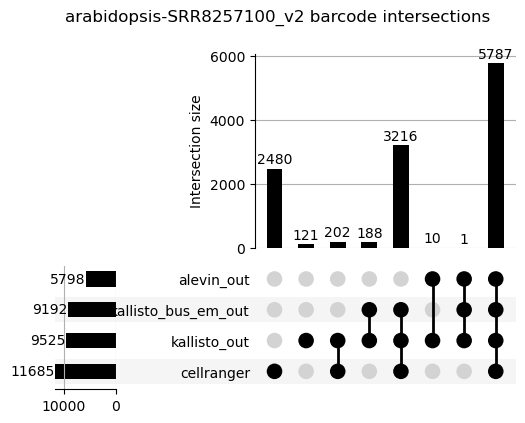

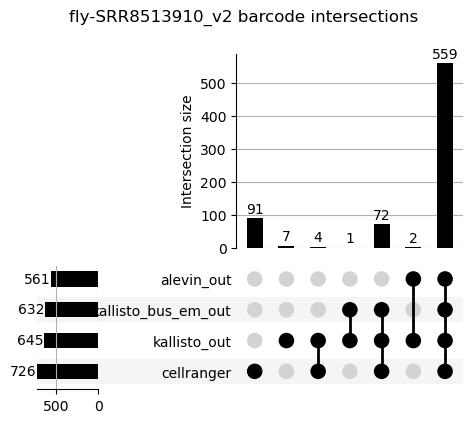

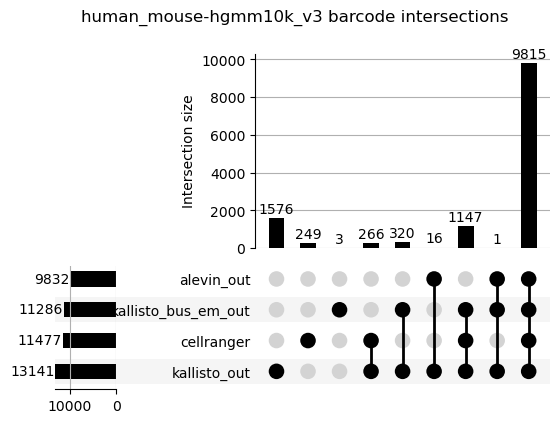

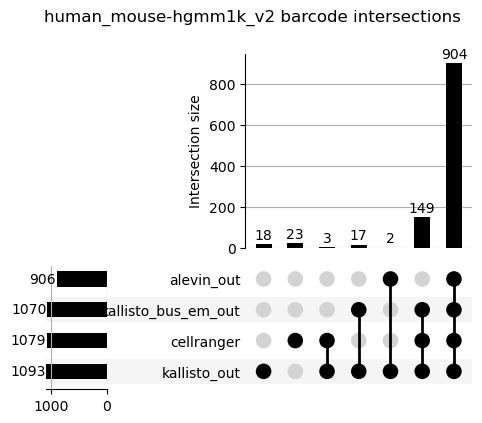

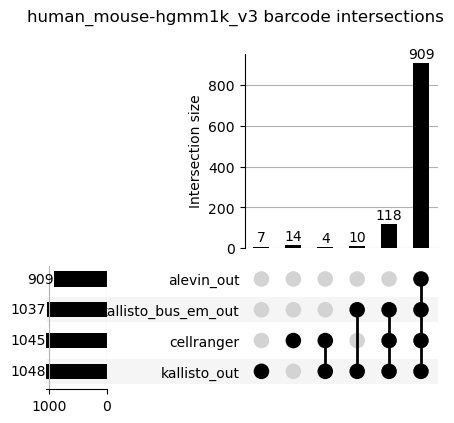

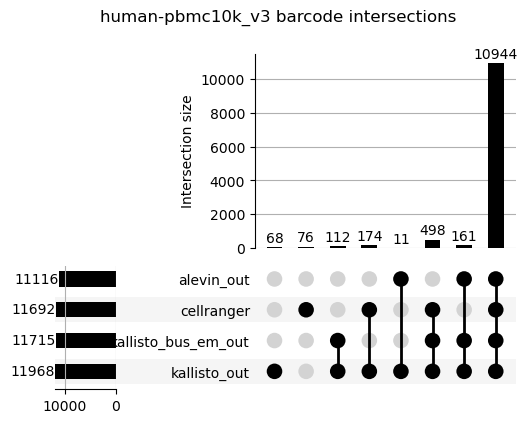

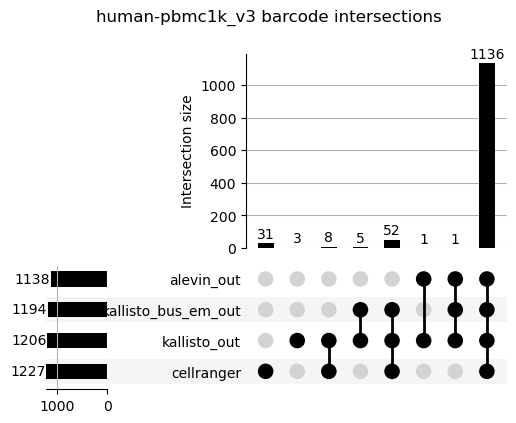

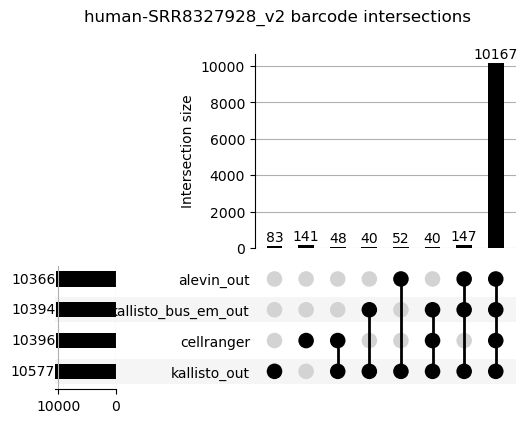

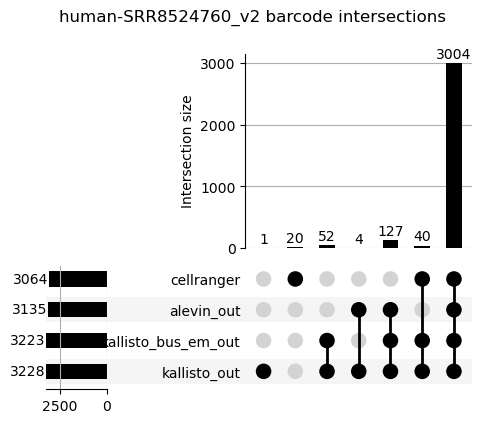

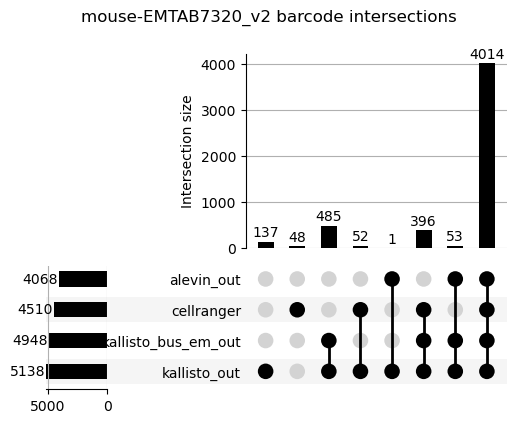

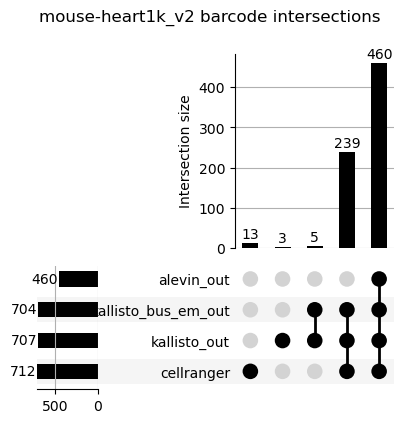

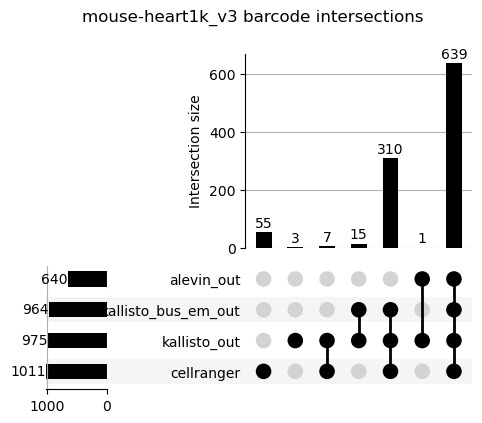

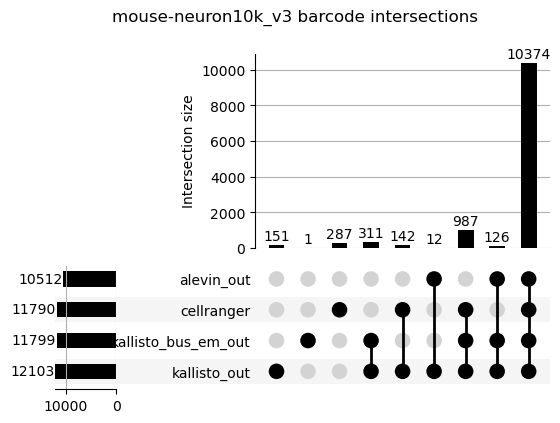

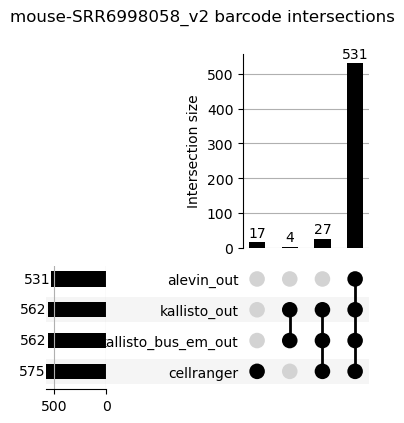

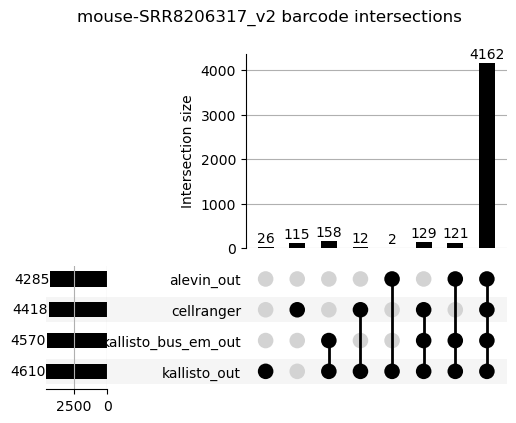

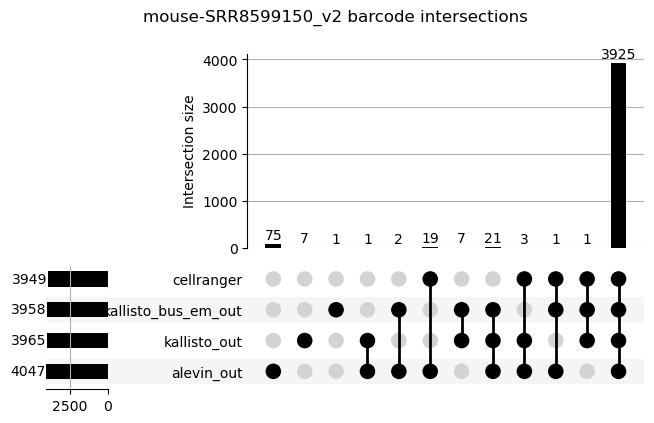

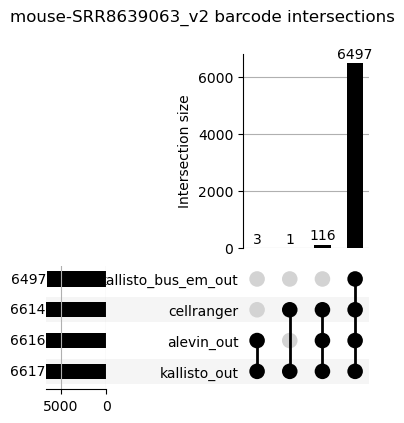

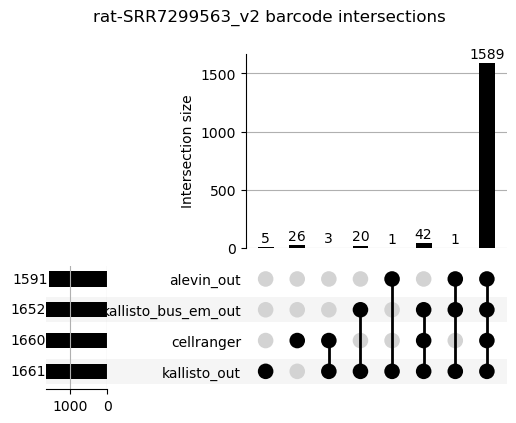

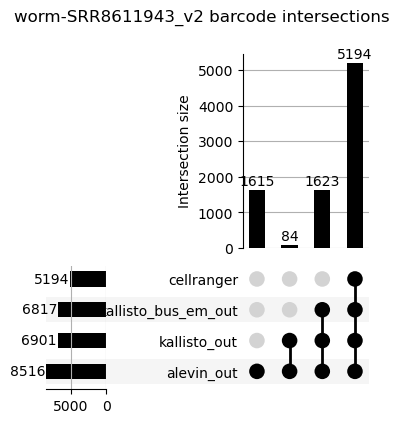

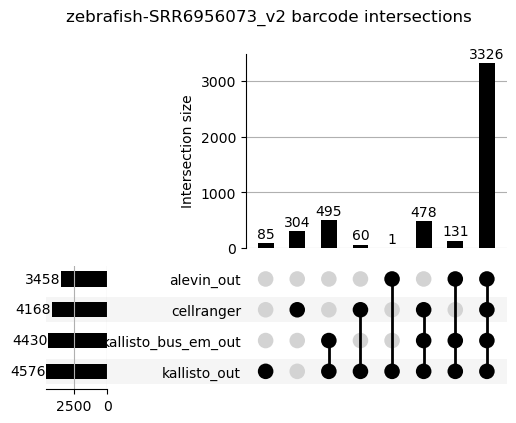

In [6]:
intersections = {}
for experiment_name in datasets.keys():
    intersections[experiment_name] = generate_permit_upset(search_path, experiment_name, permit_list_loaders)

In [7]:
def decode_index_to_names(index, index_names):
    names = []
    for i in range(len(index_names)):
        if index[i]:
            names.append(index_names[i])

    return tuple(sorted(names))

def rank_intersections(intersection):
    names = intersection.index.names
    row_intersect_values = Counter(intersection.index)
    
    value_intersect_row = []
    for intersect_row in row_intersect_values:
        value_intersect_row.append((row_intersect_values[intersect_row], intersect_row))
        
    value_intersect_row = sorted(value_intersect_row, reverse=True)
    
    ranks = {}
    for i, (count, intersect_row) in enumerate(value_intersect_row):
        ranks[decode_index_to_names(intersect_row, names)] =  i
        
    return ranks

In [8]:
ranks = []
for exeriment_name in datasets:
    experiment_rank = rank_intersections(intersections[exeriment_name])
    ranks.append(experiment_rank)
    #for algorithm_sets, rank in experiment_rank:
#        ranks.setdefault(algorithm_sets, []).append(rank)

rank_table = pandas.DataFrame(ranks, index=datasets.keys())

# Table of algorithm concordance per dataset

In [9]:
rank_table[rank_table.median().sort_values().index].fillna('')

,"(alevin_out, cellranger, kallisto_bus_em_out, kallisto_out)","(cellranger, kallisto_bus_em_out, kallisto_out)","(alevin_out,)","(cellranger,)","(kallisto_bus_em_out, kallisto_out)","(alevin_out, cellranger)","(alevin_out, cellranger, kallisto_out)","(kallisto_out,)","(alevin_out, kallisto_bus_em_out, kallisto_out)","(cellranger, kallisto_out)","(alevin_out, kallisto_out)","(alevin_out, kallisto_bus_em_out)","(kallisto_bus_em_out,)","(alevin_out, cellranger, kallisto_bus_em_out)"
arabidopsis-SRR8257100_v2,0,1,,2,4,,,5,7,3,6,,,
fly-SRR8513910_v2,0,2,,1,6,,,3,,4,5,,,
human_mouse-hgmm10k_v3,0,2,,5,3,,,1,8,4,6,,7,
human_mouse-hgmm1k_v2,0,1,,2,4,,,3,,5,6,,,
human_mouse-hgmm1k_v3,0,1,,2,3,,,4,,5,,,,
human-pbmc10k_v3,0,1,,5,4,,,6,3,2,7,,,
human-pbmc1k_v3,0,1,,2,4,,,5,6,3,7,,,
human-SRR8327928_v2,0,6,,2,7,,,3,1,5,4,,,
human-SRR8524760_v2,0,3,,4,2,,,6,1,,5,,,
mouse-EMTAB7320_v2,0,2,,6,1,,,3,4,5,7,,,


# Save union and intersection cell barcodes

In [10]:
def write_barcodes(pathname, barcodes):
    with open(pathname, 'wt') as outstream:
        for barcode in barcodes:
            outstream.write(barcode)
            outstream.write(os.linesep)

common_barcodes_dir = Path('data/common_barcodes')
for dataset_name in datasets:
    intersection = intersections[dataset_name].loc[True,True,True,True]['id'].values
    union = intersections[dataset_name]['id'].values
    print(dataset_name, len(intersection), len(union))
    intersection_filename = dataset_name + '.intersection.txt'
    union_filename = dataset_name + 'union.txt'
    write_barcodes(common_barcodes_dir / intersection_filename, intersection)
    write_barcodes(common_barcodes_dir /  union_filename, union)

arabidopsis-SRR8257100_v2 5787 12005
fly-SRR8513910_v2 559 736
human_mouse-hgmm10k_v3 9815 13393
human_mouse-hgmm1k_v2 904 1116
human_mouse-hgmm1k_v3 909 1062
human-pbmc10k_v3 10944 12044
human-pbmc1k_v3 1136 1237
human-SRR8327928_v2 10167 10718
human-SRR8524760_v2 3004 3248
mouse-EMTAB7320_v2 4014 5186
mouse-heart1k_v2 460 720
mouse-heart1k_v3 639 1030
mouse-neuron10k_v3 10374 12391
mouse-SRR6998058_v2 531 579
mouse-SRR8206317_v2 4162 4725
mouse-SRR8599150_v2 3925 4063
mouse-SRR8639063_v2 6497 6617
rat-SRR7299563_v2 1589 1687
worm-SRR8611943_v2 5194 8516
zebrafish-SRR6956073_v2 3326 4880


<ipython-input-10-53d9d1d0abde>:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  intersection = intersections[dataset_name].loc[True,True,True,True]['id'].values
